In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform, pdist
from datetime import datetime

from pathlib import Path
from tqdm.notebook import tqdm
import glob

import functions as f

### constants

In [2]:
G = 4.3009125e-3 #pc * (km/s)^2 / Msun
R_norm = 1.2262963200 #pc
V_norm = 4.587330615 #km/s
M_norm = 6.0e3 #Msun
omega = 231.38 / 8173 #km/s / pc
kappa = 1.37 * omega
nu = 2.81 * omega
gamma_sq = 4 * omega ** 2 - kappa ** 2
nu_sq = nu ** 2

In [3]:
names = np.array(['M', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M_ini', 'Z', 'Nan', 'Event',
                  'M_', 'Nan3', 'Nan4', 'Nan5', 'Nan6', 'Nan7', 'Nan8'])
names_vir = np.array(['x', 'y', 'z', 'vx', 'vy', 'vz', 'd', 'M', 'n_cum', 'Status', 
                      'U', 'K', 'vir', 'count', 'pot', 'ax', 'ay', 'az', 'potc', 'pot_ext','ax_ext', 'ay_ext',
                      'az_ext', 'potc_extc'])
data_path = Path('./data/')

In [4]:
def kinetic_energy(cluster, vxc, vyc, vzc):
    cluster_center = cluster[(cluster['x'] > xc-5) & (cluster['x'] < xc+5)]
    cluster_center = cluster_center[(cluster_center['y'] > yc-5) & (cluster_center['y'] < yc+5)]
    cluster_center = cluster_center[(cluster_center['z'] > zc-5) & (cluster_center['z'] < zc+5)]
    
#     vxc = sum(cluster_center['M'] * cluster_center['vx']) / cluster_center['M'].sum()
#     vyc = sum(cluster_center['M'] * cluster_center['vy']) / cluster_center['M'].sum()
#     vzc = sum(cluster_center['M'] * cluster_center['vz']) / cluster_center['M'].sum()
    
    K = cluster['M'] / 2 * ((cluster['vx'] - vxc) ** 2 + 
                            (cluster['vy'] - vyc) ** 2 + 
                            (cluster['vz'] - vzc) ** 2)
    return K

In [5]:
def potential_energy(cluster, xc, yc, zc):
    EPS = 1.0e-4 * R_norm
    dist_matrix = squareform(pdist(cluster[['x', 'y', 'z']].to_numpy(), 'euclidean'))
    eps_matrix = (np.ones_like(dist_matrix) - np.identity(len(cluster))) * EPS
    dist_matrix_corr = np.sqrt(dist_matrix ** 2 + eps_matrix ** 2)
    
    reversed_dists_sq = 1 / (dist_matrix_corr + np.identity(len(cluster))) - np.identity(len(cluster))
    U = -(reversed_dists_sq @ cluster['M']) * G * cluster['M'] 
                ## equal to np.sum(dist_matrix * cluster['M'].to_numpy(), axis=1)
        
    phi = np.arctan2(yc, xc)
    x_ = cluster['x'] * np.cos(phi) + cluster['y'] * np.sin(phi) - np.sqrt((yc) ** 2 + (xc) ** 2)
    #U = - U - cluster['M'] * (gamma_sq * x_ ** 2 - nu_sq * (cluster['z'] - zc) ** 2) / 2
    
    return U #U.mean(), (gamma_sq * x_ ** 2 / 2).mean(), (nu_sq * (cluster['z'] - zc) ** 2 / 2).mean()

In [11]:
gamma = 2.0
sfe = '0.20'
time = 800

In [12]:
folder = f'./../gamma={gamma}/run-{gamma}-{sfe}-22'

In [14]:
#cluster_mass = pd.read_csv(f'{gamma}_{sfe}_22_{time}.mass', delimiter='\s+', header=None)
cluster = pd.read_csv(f'{folder}/{f.get_filename(time)}', delimiter='\s+', header=None, skiprows=3,
                  names=names)
density_cs = pd.read_csv(f'{folder}/def_dc.dat', delimiter='\s+', index_col=0, header=None)

FileNotFoundError: [Errno 2] No such file or directory: './../gamma=2.0/run-2.0-0.20-22/def_dc.dat'

In [ ]:
cluster = f.normalize_cluster(cluster)

In [20]:
xc, yc, zc = density_cs.iloc[time, 1:4]
vxc, vyc, vzc = density_cs.iloc[time, 4:7]

### checking

In [21]:
# vxc, vyc, vzc = (cluster.loc[:, ('vx', 'vy', 'vz')] - 
#                  cluster_vir.loc[:, ('vx', 'vy', 'vz')] * V_norm).to_numpy().T

In [8]:
cluster_vir = pd.read_csv(f'{folder}/{f.get_filename(time)}', delimiter='\s+', header=None, index_col=0,
                         names=names_vir)
cluster_vir.sort_index(inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: './../gamma=2.0/run-2.0-0.2-22'

In [13]:
(cluster_vir['vx'] * V_norm - (cluster['vx'] - vxc))[1:]

1       -0.004273
2       -0.004273
3       -0.004273
4       -0.004273
5       -0.004273
           ...   
10450   -0.004273
10451   -0.004273
10452   -0.004273
10453   -0.004273
10454   -0.004273
Name: vx, Length: 10454, dtype: float64

In [14]:
(cluster_vir['y'] * R_norm - (cluster['y'] - yc))[1:]

1       -0.000001
2       -0.000001
3       -0.000001
4       -0.000001
5       -0.000001
           ...   
10450   -0.000001
10451   -0.000001
10452   -0.000001
10453   -0.000001
10454   -0.000001
Name: y, Length: 10454, dtype: float64

### kinetic energy

In [15]:
cluster['K'] = kinetic_energy(cluster, vxc, vyc, vzc)

<AxesSubplot:>

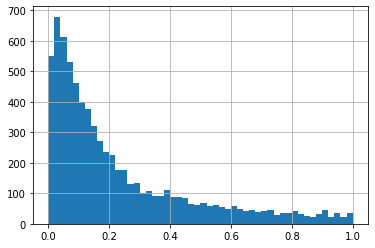

In [16]:
cluster['K'][cluster['K']<1].hist(bins=50)

### potential Energy

In [17]:
cluster['U'] = potential_energy(cluster, xc, yc, zc)

### virial ratio

In [18]:
cluster['K'].sum() / (cluster['U'].sum() / 2)

-2484.2415404651388

Text(0, 0.5, 'z, pc')

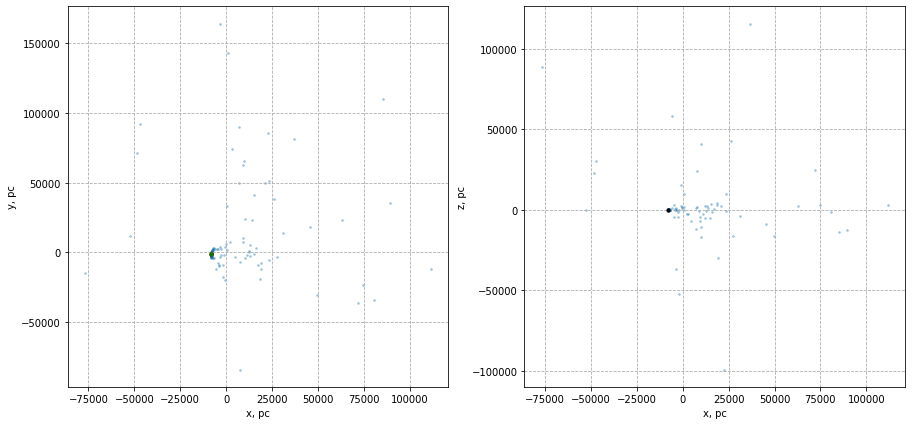

In [20]:
fig, ax = plt.subplots(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.scatter(cluster['x'], cluster['y'], s=3, alpha=0.3)
plt.scatter([xc], [yc], zorder=100, c='black', s=10)
plt.scatter(cluster.loc[3413, 'x'], cluster.loc[3413, 'y'], s=10, alpha=1, c='red', zorder=101)
plt.scatter(cluster.loc[5437, 'x'], cluster.loc[5437, 'y'], s=10, alpha=1, c='green', zorder=102)
plt.grid(c='#aaaaaa', ls='--')
# plt.xlim(-8095,-8090)
# plt.ylim(-1207, -1202)
plt.xlabel('x, pc')
plt.ylabel('y, pc')

plt.subplot(1, 2, 2)
plt.scatter(cluster['x'], cluster['z'], s=3, alpha=0.3)
plt.scatter([xc], [zc], zorder=100, c='black', s=10)
plt.grid(c='#aaaaaa', ls='--')
plt.xlabel('x, pc')
plt.ylabel('z, pc')

### checking

Text(0.5, 0, 'Delta K')

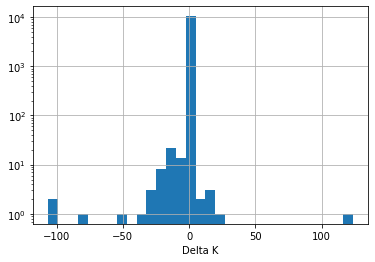

In [21]:
((cluster_vir['K'] * M_norm * V_norm ** 2 - cluster['K']))[1:].hist(bins=31, log=True)
plt.xlabel('Delta K')

Text(0.5, 0, 'Delta U')

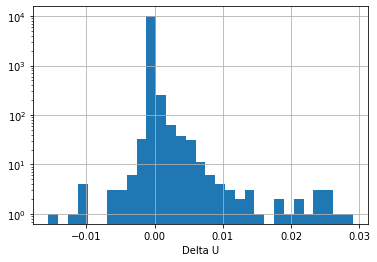

In [22]:
((cluster_vir['U'] * M_norm * V_norm ** 2 - cluster['U']))[1:].hist(bins=31, log=True)
plt.xlabel('Delta U')

In [24]:
cluster_vir['K'].sum() / (cluster_vir['U'].sum() / 2)

-2484.0960443661265

In [25]:
cluster_vir_ = cluster_vir[cluster_vir['K'] + cluster_vir['U'] < 0]
cluster_vir_['K'].sum() / (cluster_vir_['U'].sum() / 2)

-0.5063552667175839

In [26]:
cluster = cluster[cluster['K'] + cluster['U'] < 0]

In [27]:
cluster['K'].sum() / (cluster['U'].sum() / 2)

-0.5074249094712434

### loop

In [28]:
dir_ = Path('./run-1.0-0.05-22/')
density_cs = pd.read_csv(f'{1}_05_22_dc.dat', delimiter='\s+', index_col=0, header=None)
virials = []

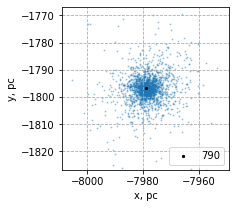

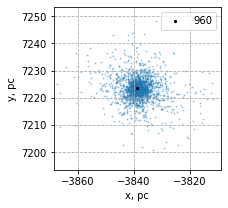

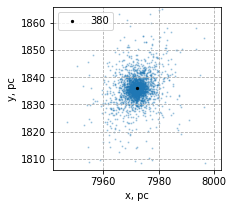

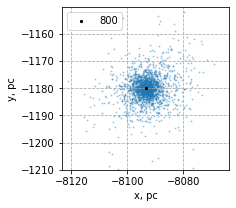

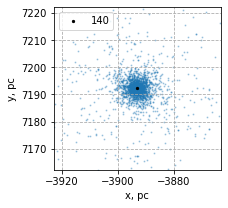

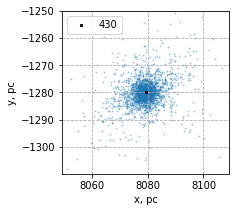

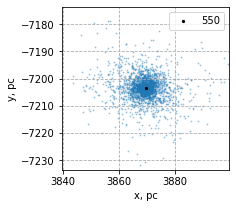

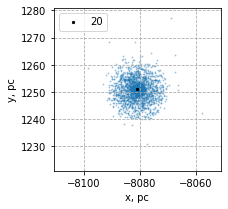

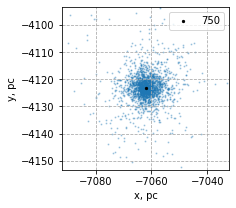

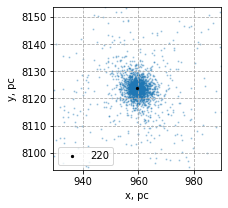

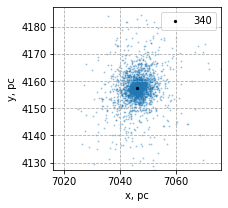

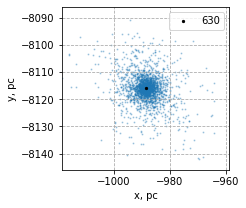

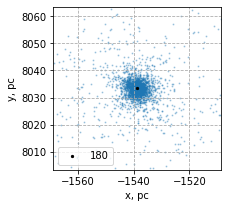

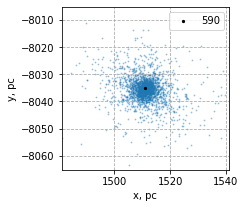

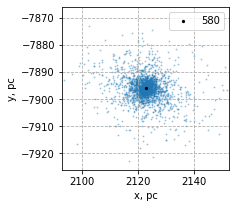

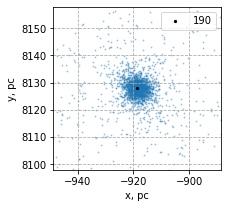

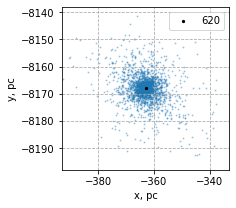

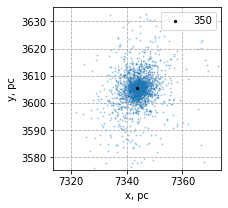

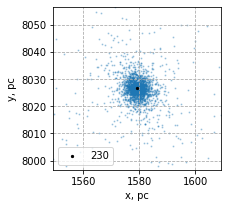

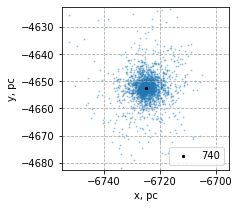

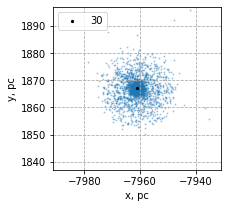

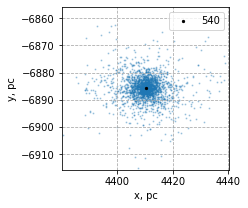

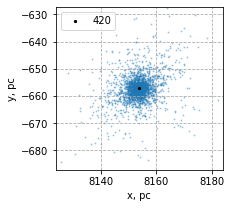

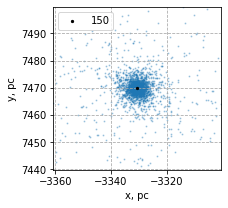

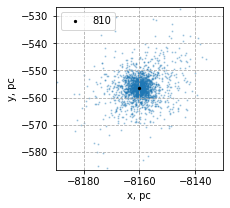

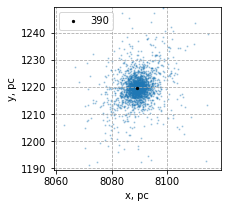

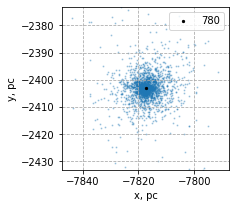

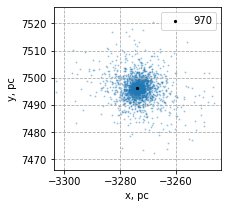

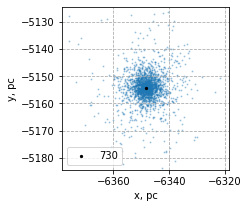

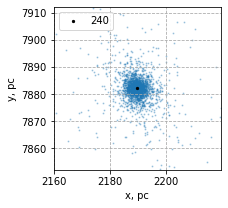

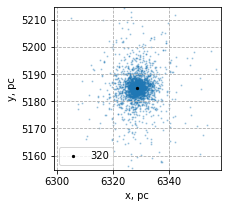

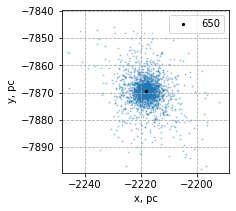

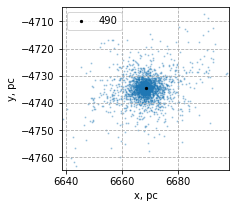

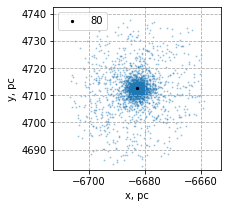

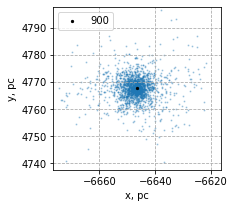

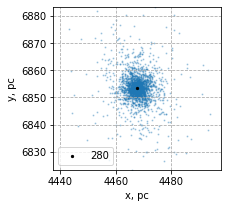

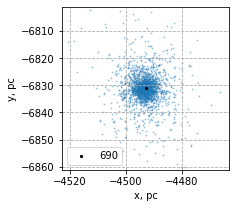

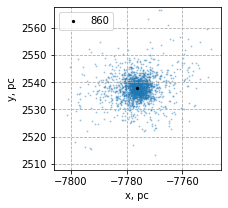

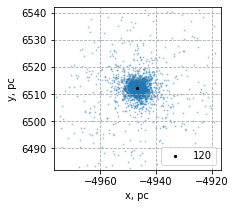

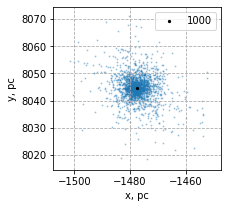

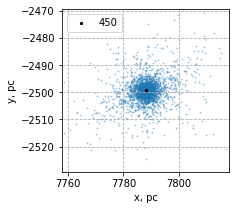

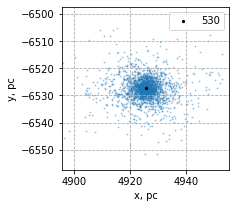

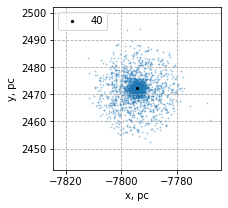

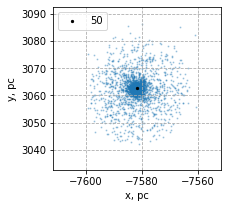

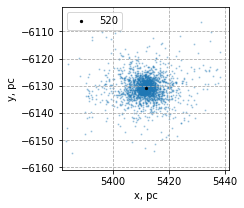

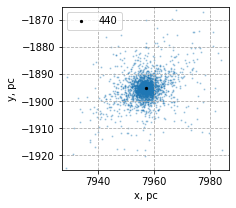

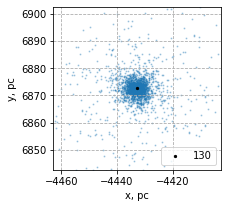

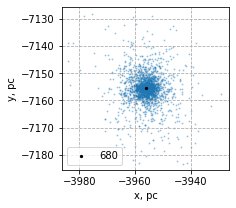

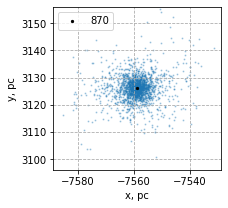

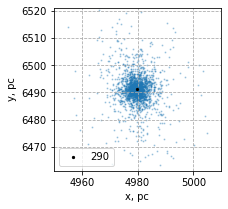

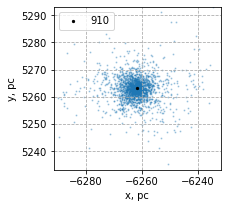

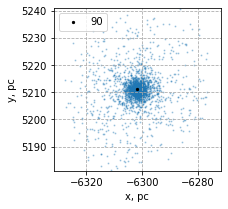

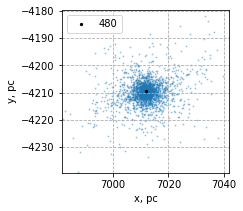

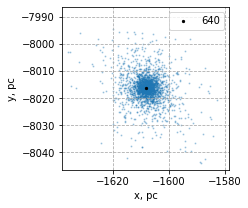

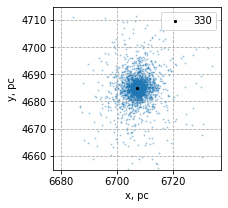

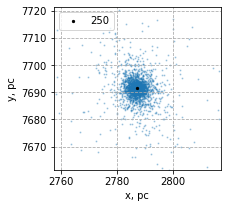

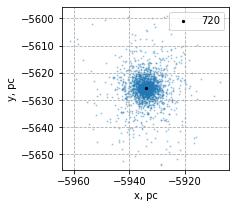

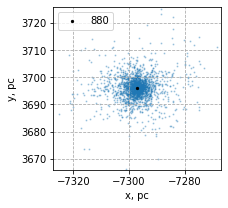

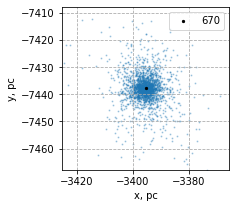

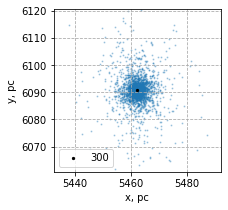

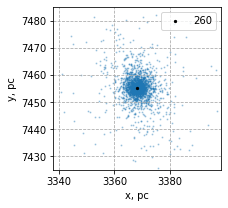

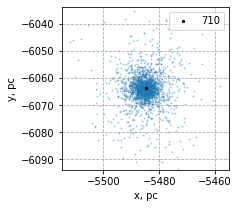

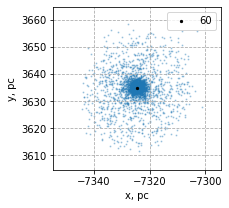

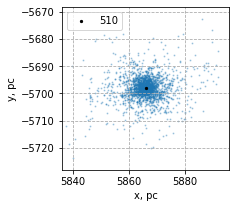

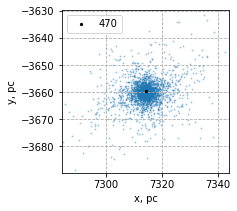

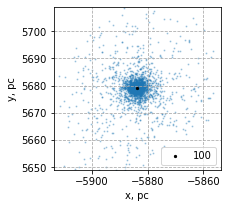

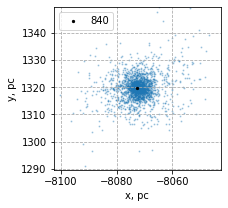

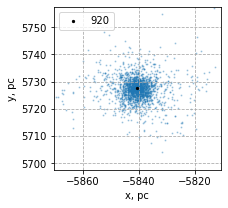

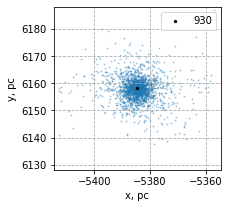

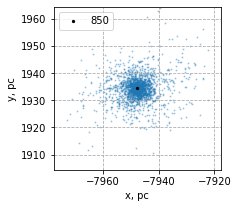

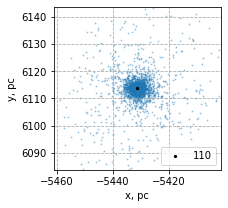

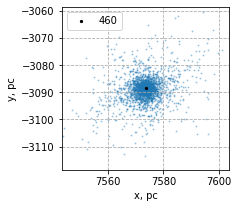

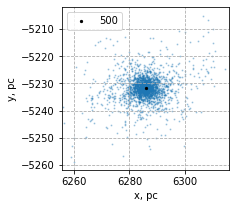

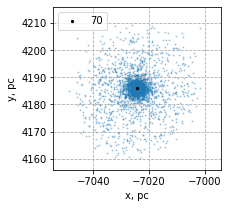

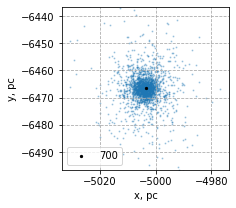

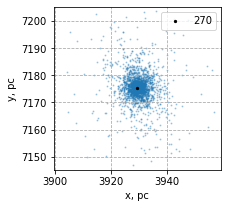

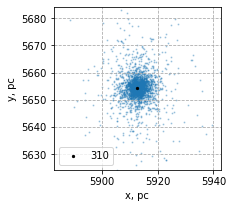

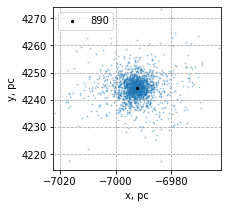

KeyboardInterrupt: 

In [136]:
with tqdm(total=len(glob.glob(f'{dir_}/*'))) as progress_bar:
    for pth in dir_.iterdir():
        snapshot = int(pth.name.split('.')[0])
        cluster = pd.read_csv(pth, delimiter='\s+', header=None, skiprows=3,
                      names=names)
        cluster = normalize_cluster(cluster)
        xc, yc, zc = density_cs.iloc[snapshot,1:4]
        vxc, vyc, vzc = density_cs.iloc[snapshot,4:7]
        time = density_cs.iloc[snapshot,0]

        cluster['K'] = kinetic_energy(cluster, vx, yc, zc)
        cluster['U'] = potential_energy(cluster, xc, yc, zc)
        cluster = cluster[cluster['K'] + cluster['U'] < 0]
        virial = cluster['K'].sum() / (cluster['U'].sum() / 2)
        virials.append([snapshot, time, virial])
        
        fig, ax = plt.subplots(figsize = (3, 3))
        plt.scatter(cluster['x'], cluster['y'], s=1, alpha=0.3)
        plt.scatter([xc], [yc], zorder=100, c='black', s=5, label=f'{snapshot}')
        plt.grid(c='#aaaaaa', ls='--')
        plt.xlabel('x, pc')
        plt.ylabel('y, pc')
        plt.legend()
        plt.xlim(xc - 30, xc + 30)
        plt.ylim(yc - 30, yc + 30)
        plt.show()

        progress_bar.update(1)

In [28]:
virials = pd.DataFrame(virials)

In [29]:
virials = virials.sort_values(by=0)

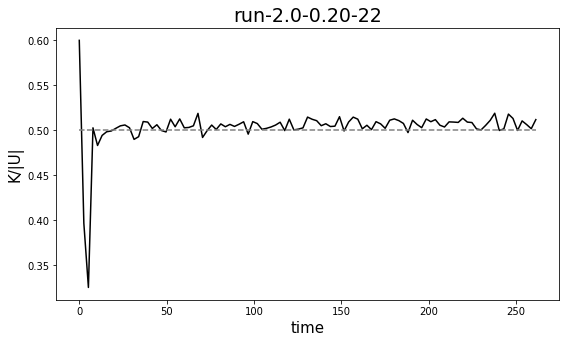

In [30]:
fig, ax = plt.subplots(figsize = (9, 5))

ax.plot(virials[1], np.abs(virials[2]), c='black')
ax.plot([0,virials[1].max()], [0.5, 0.5], c='gray', ls='--')
ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('K/|U|', fontsize=15)
ax.set_title(f'{dir_.name}', fontsize=19)
plt.savefig(f'{dir_.name}_virial.pdf', bbox_inches = 'tight')

K/P(t) (поиграть с тем, какие звезды учитывать в подсчете)
как меняется плотность (K/P)